### Figure 1. Example data diagrams

In [6]:
from Baselines.KalmanDecoder import * 
from SNNModel.dataloader import *
from Globals import *

In [129]:
FINGER2CURSOR = np.array([[0,0],[-10,0],[0,-10]])

In [44]:
import h5py
import numpy as np
import torch
from torch.utils.data import Subset
from neurobench.datasets import PrimateReaching

data_path = './data/indy_20160630_01.mat'


class Dataloader:
    def __init__(self, spike_units='all', normalize=True, center_zero=True, aggreagate_chs=True, bin_size=1, bad_ch_cutoff=1):
        """_summary_

        Args:
            spike_units: string of list of spike unit numbers to use (e.g. [0, 2, 4])
            normalize (bool, optional): _description_. Defaults to True.
            bin_size (int, optional): _description_. Defaults to 1.
            ex_cutoff : excludes spiking units that spike less than this cutoff value 
        """
        self.pr_dataset = PrimateReaching(file_path='data',
                                          filename="indy_20160630_01.mat",
                                          num_steps=1,
                                          train_ratio=0.5,
                                          bin_width=0.004,
                                          biological_delay=0,
                                          download=False)
        print("Loaded pr dataset")
        
        self.spike_units   = spike_units 
        self.normalize     = normalize 
        self.center_zero   = center_zero 
        self.aggregate_chs = aggreagate_chs
        self.bin_size      = bin_size
        self.bad_ch_cutoff = bad_ch_cutoff
        
        with h5py.File(data_path, 'r') as data:
            # initialize spike units to use 
            if spike_units == 'all': 
                n_sp = data['spikes'].shape[0]
                self.spike_units = [i for i in range(n_sp)]
            
            # get spike matrix and split into train / test set 
            spike_matrix = self._get_spike_mat(data)
            trainX, testX, train_finger_pos, test_finger_pos, train_cursor_pos, test_cursor_pos = self._train_test_split(data, spike_matrix)
            
            # bin data
            if self.bin_size > 1: 
                trainX = self._bin_data(trainX)
                testX  = self._bin_data(testX)

            # convert positions to velocity 
            trainY = self._pos2vel(train_finger_pos.numpy())
            testY = self._pos2vel(test_finger_pos.numpy())
            trainY_cursor = self._pos2vel(train_cursor_pos.numpy())
            testY_cursor = self._pos2vel(test_cursor_pos.numpy())            
            print(f'Binned into {4*self.bin_size}ms intervals')
            
            # normalize velocities if necessary 
            if self.normalize: 
                trainX, testX = self._normalize(trainX, testX)
            if self.center_zero: 
                trainY, testY = self._center_zero(trainY, testY)
                
            # exclude channels that are too sparse 
            trainX, testX = self._exclude_channels(trainX, testX)
            
            self.data = trainX, testX, trainY, testY, trainY_cursor, testY_cursor
            self.pos  = train_finger_pos, test_finger_pos, train_cursor_pos, test_cursor_pos 
            

    def _get_spike_mat(self, data): 
        # extract timesteps and spike channel params
        timesteps = torch.tensor(np.array(data['t'])).flatten()  # Ensure t is a 1D array
        n_ch = len(data['spikes'][0])  # number of channels 
        n_sp = len(self.spike_units)   # number of spike units to use for each channel
        
        # initialize spike matrix with zeros 
        n = len(timesteps)
        k = n_sp * n_ch 
        spike_matrix = np.zeros((n, k), dtype=np.float32)
        
        # read spike data and populate spike matrix 
        for sp_unit in self.spike_units: 
            for unit_idx, channel_ref in enumerate(data['spikes'][sp_unit]): 
                channel = data[channel_ref]  # Dereference the channel
                for unit_ref in channel: 
                    unit_spike_times = np.array(unit_ref).flatten()  # Dereference the unit spike times and flatten
                    spike_indices    = np.searchsorted(timesteps, unit_spike_times)
                    spike_indices    = spike_indices[spike_indices < n]  # Ensure indices are within bounds
                    spike_matrix[spike_indices, sp_unit*n_ch+unit_idx] = 1
                    
        return spike_matrix
    
    
    def _train_test_split(self, data, spike_matrix):
        finger_pos = torch.tensor(np.array(data['finger_pos']).T)  # Ensure proper shape and convert to PyTorch tensor
        cursor_pos = torch.tensor(np.array(data['cursor_pos']).T)  # Ensure proper shape and convert to PyTorch tensor
        # get train and test indices
        train_idx = self.pr_dataset.ind_train
        test_idx  = self.pr_dataset.ind_test
        
        train_neural = spike_matrix[train_idx]
        test_neural  = spike_matrix[test_idx]
        
        train_finger_pos = finger_pos[train_idx][:,:3]  # extract z, -x, -y positions and drop spherical coords
        test_finger_pos  = finger_pos[test_idx][:,:3]   # extract z, -x, -y positions and drop spherical coords
        
        train_cursor_pos = cursor_pos[train_idx]
        test_cursor_pos  = cursor_pos[test_idx]
        
        return train_neural, test_neural, train_finger_pos, test_finger_pos, train_cursor_pos, test_cursor_pos
        
        
    def _bin_data(self, neural): 
        n_samples, n_spikes = neural.shape
        n_bins = int(np.ceil(n_samples / self.bin_size))
        
        X = np.zeros(shape=(n_bins, n_spikes), dtype=np.float32)
        for bin, i in enumerate(range(0, n_samples, self.bin_size)): 
            X[bin] = np.sum(neural[i:i+self.bin_size], axis=0)
        
        return X


    def _pos2vel(self, y): 
        n_samples, n_outputs = y.shape
        n_bins = int(np.ceil(n_samples / self.bin_size))
        
        y_vel = np.zeros(shape=(n_bins, n_outputs), dtype=np.float32)
        for bin, i in enumerate(range(0, n_samples, self.bin_size)): 
            binned_y = y[i:i+self.bin_size]
            y_vel[bin] = binned_y[-1] - binned_y[0]
        
        return y_vel
        
    
    def _normalize(self, trainX, testX): 
        mean = np.mean(trainX, axis=0, keepdims=True)
        std  = np.std(trainX, axis=0, keepdims=True)
        
        return (trainX - mean) / std, (testX - mean) / std
    
    
    def _center_zero(self, trainY, testY): 
        print(trainY.shape)
        mean = np.mean(trainY, axis=0, keepdims=True)
        self.finger_mean_vel = mean 
        return trainY - mean, testY - mean
        
    
    def _exclude_channels(self, trainX, testX): 
        train_chs = np.sum(trainX, axis=0) > self.bad_ch_cutoff
        test_chs  = np.sum(testX, axis=0) > self.bad_ch_cutoff
        all_chs   = np.logical_and(train_chs, test_chs)
        
        return trainX[:,all_chs], testX[:,all_chs]
    
    
    def __call__(self): 
        return self.data


In [45]:
dataloader = Dataloader(spike_units='all', normalize=False, center_zero=True, bin_size=25, bad_ch_cutoff=-1)

Loading indy_20160630_01.mat
Loaded pr dataset
Binned into 100ms intervals
(6899, 3)


In [155]:
trainX_no_lag, testX_no_lag, trainY_no_lag, testY_no_lag, trainY_cursor_no_lag, testY_cursor_no_lag = dataloader()
train_finger_pos, test_finger_pos, train_cursor_pos, test_cursor_pos = dataloader.pos

In [119]:
lag = 0 # we will assume a 200ms lag

# realign data to take lag into account 
trainY = trainY_no_lag; testY = testY_no_lag
trainY_cursor = trainY_cursor_no_lag; testY_cursor = testY_cursor_no_lag
trainX = trainX_no_lag; testX = testX_no_lag

In [120]:
# aggreagate all channels

trainX0 = np.zeros(shape=(trainX.shape[0], 96))

for i in range(1, 5): 
    trainX0 += trainX[:,96*i:96*(i+1)] 
trainX = trainX0

testX0 = np.zeros(shape=(testX.shape[0], 96))

for i in range(1, 5): 
    testX0 += testX[:,96*i:96*(i+1)] 
testX = testX0

In [121]:
dataloader2 = Dataloader(spike_units='all', normalize=False, center_zero=False, bin_size=2, bad_ch_cutoff=-1)

Loading indy_20160630_01.mat
Loaded pr dataset
Binned into 8ms intervals


In [122]:
_, _, y_train_vel_disp, _, _, _ = dataloader2()

In [123]:
def vel2pos(pos, vel): 
    n_outputs = vel.shape[1]
    pos0 = pos[0,:].numpy()
    vel_cumsum = np.concatenate([np.zeros([1, n_outputs]), np.cumsum(vel, axis=0)], axis=0)
    displacement = vel_cumsum 
    return pos0 + displacement

In [128]:
trainY.shape

(6899, 3)

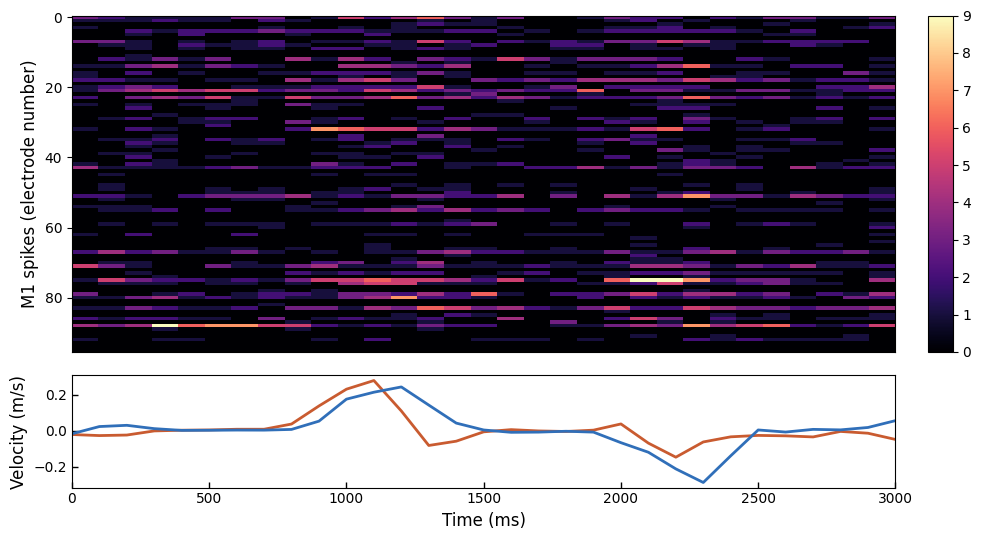

In [176]:
# plot first 1 second 

import matplotlib.pyplot as plt 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib as mpl

# Create a figure
fig = plt.figure(figsize=(10, 5.5))  # Adjust the size as needed

# Set up GridSpec
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[20, .6])

plot_cursor_vel = trainY @ FINGER2CURSOR

# Add plots
ax0 = fig.add_subplot(gs[0, 0])  # First plot for the heatmap
ax1 = fig.add_subplot(gs[1, 0])  # Second plot for the first line plot

neural_array = trainX.T[:,1510:1541]

# Plotting the heatmap
t = np.linspace(0, 3000, 31)
x_t = np.linspace(0, 3000, 7)
heatmap = ax0.imshow(neural_array, cmap=mpl.colormaps['magma'], aspect='auto')
ax0.set_ylabel('M1 spikes (electrode number)', fontsize=12)
ax0.set_xticks([])
# Adding the colorbar
axc = fig.add_subplot(gs[0, 1])
plt.colorbar(heatmap, cax=axc)


# Plotting the first line plot
ax1.plot(t, 0.01 * plot_cursor_vel[1510:1541,0], color='#C95B30', linewidth=2)
ax1.set_xlabel('Time (ms)', fontsize=12)
ax1.set_ylabel('Velocity (m/s)', fontsize=12)

# Plotting the second line plot
ax1.plot(t, 0.01 * plot_cursor_vel[1510:1541,1], color='#306FB9', linewidth=2)
ax1.set_xlim([0,3])
ax1.set_xticks(x_t)
ax1.tick_params(direction='in', width=1, length=4)

# Improve the layout
plt.tight_layout()

# Display the plot
plt.show()


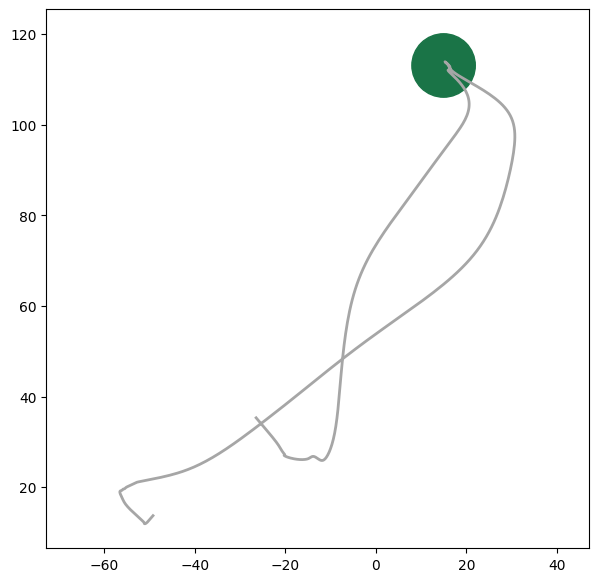

In [224]:
import matplotlib.patches as patches

# Create a figure and an axes
fig, ax = plt.subplots(figsize=(7, 7))

# Define the position and radius of the circle
x, y = train_cursor_pos.numpy()[1510*25:1530*25-20][-1]
radius = 7  # Example radius

# Create a circle patch
circle = patches.Circle((x-1, y+1), radius, color='#1A7447')
# Add the circle to the axes
ax.add_patch(circle)

# Set equal scaling by changing the aspect ratio of the plot
ax.set_aspect('equal', adjustable='datalim')

cursor_loc = train_cursor_pos.numpy()[1510*25:1541*25-1]
ax.plot(cursor_loc[:,0], cursor_loc[:,1], color='#A6A6A6', linewidth=2)

    
# Display the plot
plt.show()


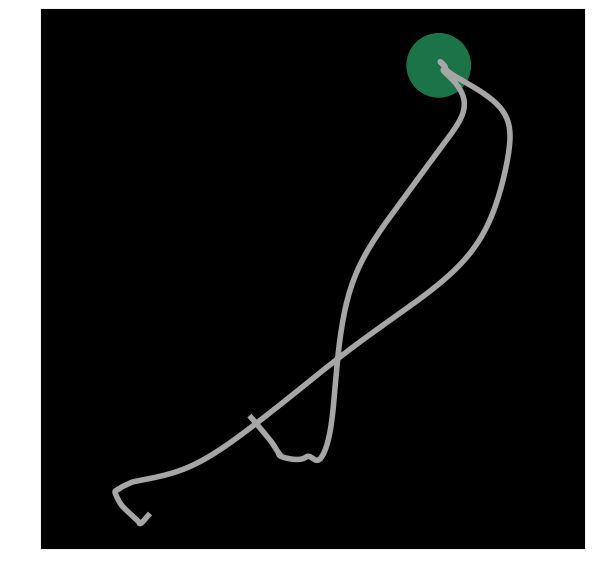

In [228]:
import matplotlib.patches as patches

# Create a figure and an axes
fig, ax = plt.subplots(figsize=(7, 7))

# Define the position and radius of the circle
x, y = train_cursor_pos.numpy()[1510*25:1530*25-20][-1]
radius = 7  # Example radius

# Create a circle patch
circle = patches.Circle((x-1, y+1), radius, color='#1A7447')
# Add the circle to the axes
ax.add_patch(circle)

# Set equal scaling by changing the aspect ratio of the plot
ax.set_aspect('equal', adjustable='datalim')
ax.set_facecolor('black')
#fig.patch.set_facecolor('black')

cursor_loc = train_cursor_pos.numpy()[1510*25:1541*25-1]
ax.plot(cursor_loc[:,0], cursor_loc[:,1], color='#A6A6A6', linewidth=4)
ax.tick_params(axis='both', direction='in', width=2, length=0)
ax.tick_params(colors='white', which='both')  # Change tick color to white


# Display the plot
plt.show()


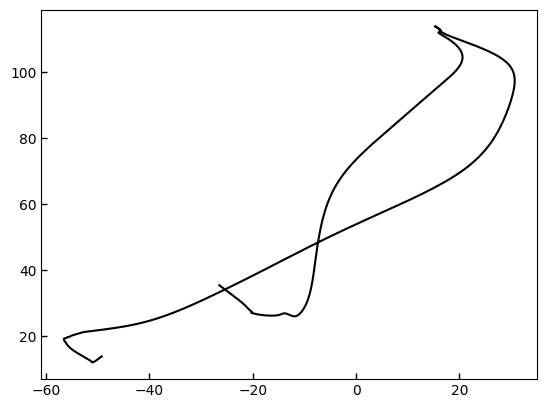

In [186]:
cursor_loc = 




plt.show()

In [159]:
trainX.shape

(6899, 96)